In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
#!unzip -q ~/data/salt_keras/train.zip -d ~/data/salt_keras/train
#!unzip -q ~/data/salt_keras/test.zip -d ~/data/salt_keras/test


In [33]:
# Set some parameters
im_width = 32
im_height = 32
border = 5
path_train = '/home/labis/data/salt_keras/train/'
path_test = '/home/labis/data/salt_keras/test/'

In [34]:
from tqdm import tqdm


# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "images"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (im_width, im_height, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
            mask = resize(mask, (im_width, im_height, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

100%|██████████| 2/2 [00:00<00:00, 183.28it/s]

Getting and resizing images ... 
Done!


In [35]:
print(X.shape)

(2, 32, 32, 1)


In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2020)
print(X_train.shape)

(1, 32, 32, 1)


Text(0.5, 1.0, 'Salt')

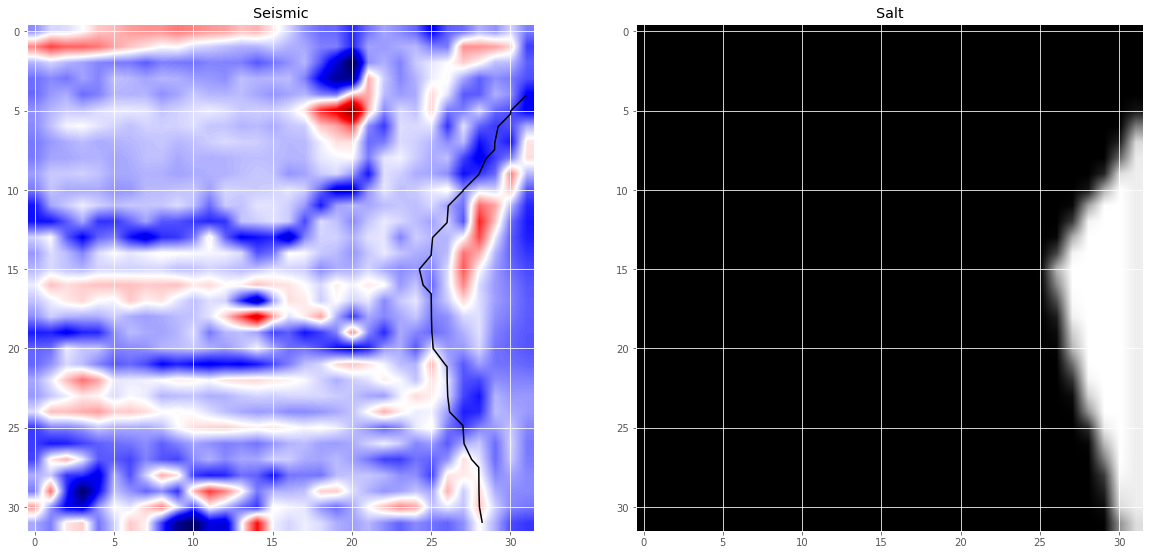

In [37]:
ix = random.randint(0,len(X_train)-1) ### -1 needed...
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].imshow(X_train[ix,...,0], cmap='seismic', interpolation = 'bilinear')

if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')


ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt')

In [38]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = False):
    
    x = Conv2D(filters = n_filters, kernel_size =(kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = n_filters, kernel_size =(kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [39]:
def get_unet(input_img,n_filters = 16, dropout = 0.5, batchnorm = False):
    #Encoder part
    c1 = conv2d_block(input_img,n_filters=n_filters,kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D(2,2)(c1)
    #p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    
    u6 = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same') (c2)
    u6 = concatenate([u6, c1])
    #u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters, kernel_size=3, batchnorm=batchnorm)
    """
    p2 = MaxPooling2D((2, 2)) (c2)
    #p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    #p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    #p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    #Decoder part
    
    u6 = Conv2DTranspose(n_filters*8, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    #u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    #u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    #u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    #u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    """
    outputs = outputs = Conv2D(1, (1, 1), activation='sigmoid') (c6)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
    

In [40]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 16)   160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 32, 32, 16)   64          conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 32, 32, 16)   0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

In [48]:
results = model.fit(X_train, y_train, batch_size=1, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 9ms/step - loss: -518.3572 - accuracy: 0.8428
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: -520.0115 - accuracy: 0.8428
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: -521.6708 - accuracy: 0.8428
Epoch 4/100
1/1 [==============================] - 0s 8ms/step - loss: -523.3330 - accuracy: 0.8428
Epoch 5/100
1/1 [==============================] - 0s 7ms/step - loss: -524.9979 - accuracy: 0.8428
Epoch 6/100
1/1 [==============================] - 0s 9ms/step - loss: -526.6659 - accuracy: 0.8428
Epoch 7/100
1/1 [==============================] - 0s 8ms/step - loss: -528.3359 - accuracy: 0.8428
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: -530.0092 - accuracy: 0.8428
Epoch 9/100
1/1 [==============================] - 0s 10ms/step - loss: -531.6830 - accuracy: 0.8428
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: -533.3616 - accuracy: 0.8

Epoch 82/100
1/1 [==============================] - 0s 11ms/step - loss: -661.6021 - accuracy: 0.8320
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: -663.4863 - accuracy: 0.8320
Epoch 84/100
1/1 [==============================] - 0s 14ms/step - loss: -665.3735 - accuracy: 0.8320
Epoch 85/100
1/1 [==============================] - 0s 9ms/step - loss: -667.2633 - accuracy: 0.8330
Epoch 86/100
1/1 [==============================] - 0s 8ms/step - loss: -669.1558 - accuracy: 0.8301
Epoch 87/100
1/1 [==============================] - 0s 7ms/step - loss: -671.0521 - accuracy: 0.8330
Epoch 88/100
1/1 [==============================] - 0s 8ms/step - loss: -672.9520 - accuracy: 0.8301
Epoch 89/100
1/1 [==============================] - 0s 10ms/step - loss: -674.8555 - accuracy: 0.8311
Epoch 90/100
1/1 [==============================] - 0s 10ms/step - loss: -676.7614 - accuracy: 0.8301
Epoch 91/100
1/1 [==============================] - 0s 8ms/step - loss: -678.6688 - acc

KeyError: 'val_loss'

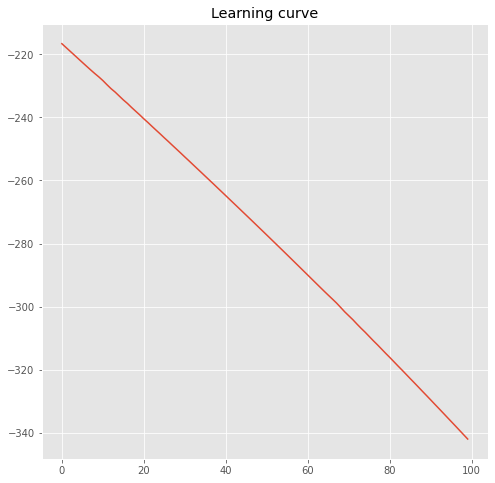

In [102]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

In [49]:
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 5ms/step


[-576.0860595703125, 0.0732421875]

In [50]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 3ms/step


In [51]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary')

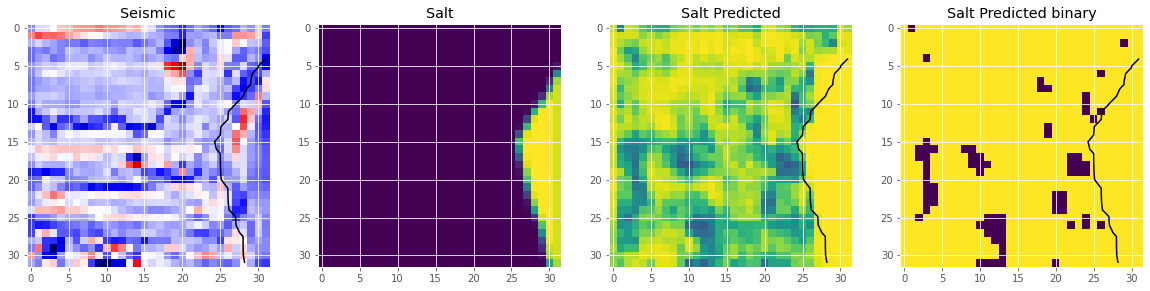

In [52]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=0)

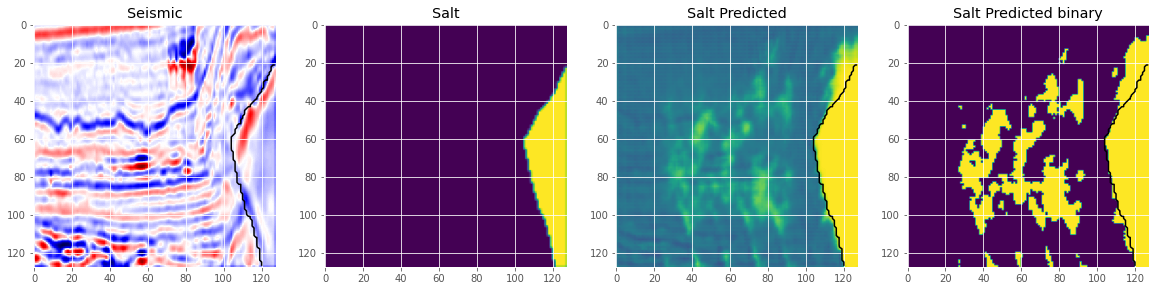

In [109]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=0)